In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl

In [4]:
DIMENSIONS = [2, 5, 10]  # Different problem sizes
BITS_PER_DIMENSION = 16  # Number of bits per dimension for binary encoding
DOMAIN_MIN = -10         # Minimum value for each dimension in the domain
DOMAIN_MAX = 10          # Maximum value for each dimension in the domain
MAX_EVALUATIONS = 10000  # Maximum number of function evaluations
REPETITIONS = 100        # Number of repetitions for averaging results

In [27]:
def generate_initial_solution(dimensions: int, bits_per_dimension: int = BITS_PER_DIMENSION) -> list[str]:
    """
    Generates the initial binary solution at the upper bound of the domain.
    
    Parameters:
    - dimensions: The number of dimensions for the problem.
    - bits_per_dimension: The number of bits used to represent each dimension.
    
    Returns:
    - A list of binary strings, each representing a dimension initialized at the maximum value.
    """
    return ['1' * bits_per_dimension for _ in range(dimensions)]  # List of binary strings, each fully set to '1'

In [6]:
def binary_to_real(binary_str: str, min_val: float = DOMAIN_MIN, max_val: float = DOMAIN_MAX) -> float:
    """
    Converts a binary string to a real value within a specified range.
    
    Parameters:
    - binary_str: A string representing the binary code (e.g., '10101101').
    - min_val: The minimum value of the range.
    - max_val: The maximum value of the range.
    
    Returns:
    - A float representing the real value decoded from the binary string, within the range [min_val, max_val].
    """
    decimal_value = int(binary_str, 2)
    max_decimal = 2**len(binary_str) - 1  # Maximum integer value possible with this many bits
    # Scale the integer value to the range [min_val, max_val]
    return min_val + (max_val - min_val) * decimal_value / max_decimal

In [7]:
def decode_solution(binary_solution: list[str]) -> list[float]:
    """
    Decodes a binary solution into real values within the domain.
    
    Parameters:
    - binary_solution: A list of binary strings, each representing a dimension.
    
    Returns:
    - A list of floats, where each float is the real value corresponding to a dimension.
    """
    return [binary_to_real(bits) for bits in binary_solution]  # Convert each binary string to its real value

In [8]:
def evaluate(solution: list[float]) -> float:
    """
    Evaluates the objective function (parabola) for a given solution.
    
    Parameters:
    - solution: A list of real numbers representing the solution.
    
    Returns:
    - A float representing the value of the evaluation function at the given solution point.
    """
    return sum(x**2 for x in solution)  # Sum of squares of all elements in the solution

In [9]:
def generate_neighbor(binary_solution: list[str]) -> list[str]:
    """
    Generates a neighbor by flipping one bit in the binary solution randomly.
    
    Parameters:
    - binary_solution: A list of binary strings, each representing a dimension.
    
    Returns:
    - A list of binary strings representing the new neighboring solution.
    """
    new_solution = binary_solution.copy()  # Copy the current solution to modify it
    dim = np.random.randint(len(binary_solution))  # Randomly choose a dimension to modify
    bit = np.random.randint(len(binary_solution[dim]))  # Randomly choose a bit in that dimension to flip
    
    # Flip the chosen bit
    new_solution[dim] = (
        new_solution[dim][:bit] + 
        ('1' if new_solution[dim][bit] == '0' else '0') + 
        new_solution[dim][bit+1:]
    )
    return new_solution

In [10]:
def first_improvement_local_search(dimensions: int, max_evaluations: int = MAX_EVALUATIONS, bits_per_dimension: int = BITS_PER_DIMENSION) -> list[float]:
    """
    Implements the First Improvement Local Search algorithm.
    
    Parameters:
    - dimensions: The number of dimensions for the problem.
    - max_evaluations: Maximum number of evaluations allowed for the function.
    - bits_per_dimension: Number of bits used to represent each dimension.
    
    Returns:
    - A list of function values representing the best found solution at each step.
    """
    solution: list[str] = generate_initial_solution(dimensions, bits_per_dimension)
    best_value: int = evaluate(decode_solution(solution))
    evaluations: list[float] = [best_value]  # List to track function values over time
    eval_count: int = 1
    
    while eval_count < max_evaluations:
        neighbor: list[str] = generate_neighbor(solution)
        neighbor_value: int = evaluate(decode_solution(neighbor))
        eval_count += 1
        
        if neighbor_value < best_value:
            solution = neighbor
            best_value = neighbor_value
        
        evaluations.append(best_value)  # Keep the best value found so far
        
    return evaluations

In [11]:
def run_experiment(dimensions_list: list[int], repetitions: int = REPETITIONS, max_evaluations: int = MAX_EVALUATIONS):
    """
    Runs the optimization experiment for multiple dimensions and repetitions.
    
    Parameters:
    - dimensions_list: List of different dimensional values (e.g., [2, 5, 10]).
    - repetitions: Number of repetitions for each dimension.
    - max_evaluations: Maximum number of evaluations per run.
    
    Returns:
    - A dictionary where each key is a dimension, and the value is a DataFrame of results.
    """
    results = {}
    
    for dim in dimensions_list:
        all_runs = []
        for _ in range(repetitions):
            best_values = first_improvement_local_search(dimensions=dim, max_evaluations=max_evaluations)
            all_runs.append(best_values)
        
        # Store the results in a DataFrame for each dimension
        df = pd.DataFrame(all_runs).T  # Transpose to get evaluations in columns
        results[dim] = df
    
    return results

In [28]:
def plot_results(results: dict):
    """
    Plots the averaged results for each dimension.
    
    Parameters:
    - results: A dictionary where each key is a dimension, and the value is a DataFrame of results.
    """
    plt.figure(figsize=(10, 6))
    
    for dim, df in results.items():
        mean_values = df.mean(axis=1)  # Average across all runs
        plt.plot(mean_values, label=f'Dimension {dim}')
    
    plt.xlabel('Evaluation Count')
    plt.ylabel('Best Function Value Found')
    plt.yscale('log')
    plt.title('Averaged Optimization Performance Across Dimensions')
    plt.legend()
    plt.show()

In [13]:
def save_to_excel(results: dict, filename: str = 'optimization_results.xlsx'):
    """
    Saves the experiment results to an Excel file with separate sheets for each dimension.
    
    Parameters:
    - results: A dictionary where each key is a dimension, and the value is a DataFrame of results.
    - filename: The name of the Excel file to save.
    """
    with pd.ExcelWriter(filename) as writer:
        for dim, df in results.items():
            df.to_excel(writer, sheet_name=f'Dimensions_{dim}')

In [16]:
results = run_experiment(DIMENSIONS)  # Run the experiment

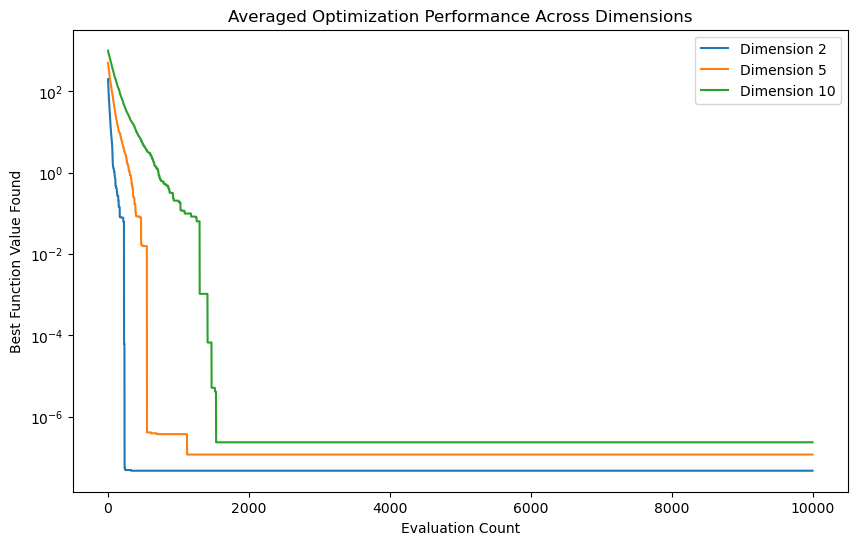

In [29]:
plot_results(results)  # Plot the results

In [18]:
save_to_excel(results)  # Save to Excel